In [82]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
from rasterio.plot import show
from shapely.geometry import box

In [83]:
code_path = Path().absolute()
datafd_path = code_path.parent.parent / 'data'
# intmd_outfd_path = code_path.parent.parent / 'output_intmd' / 'match_CPA_CDB'

In [173]:
# Read the polygon file
CF_path = datafd_path / 'CF' / 'Cambodia' / \
    'All_CF_Cambodia_July_2016_DISES_v1' / \
    'All_CF_Cambodia_July_2016_DISES_v1.shp'
polygons = gpd.read_file(CF_path)  # EPSG:3148

# Read the raster file
raster_file = datafd_path / 'DisturbanceData'/ 'year_of_disturbance.tif'
raster = rasterio.open(raster_file, 'r+')  # EPSG:32648

### preprocess

In [85]:
polygons_proj = polygons.to_crs(raster.crs)

In [174]:
yod = raster.read(1)  # band 1

In [178]:
# Read the data from the raster
data = raster.read()

# Replace all the values with the desired value
data.fill(1)

# Write the updated data back to the raster dataset
raster.write(data)

### explore

#### explore raster

In [10]:
raster.count  # n bands

1

In [11]:
raster.width, raster.height

(8876, 9411)

In [12]:
raster.dtypes

('int16',)

In [13]:
raster.bounds

BoundingBox(left=432120.0, bottom=1315260.0, right=698400.0, top=1597590.0)

In [14]:
raster.crs

CRS.from_epsg(32648)

### visualize

<AxesSubplot:>

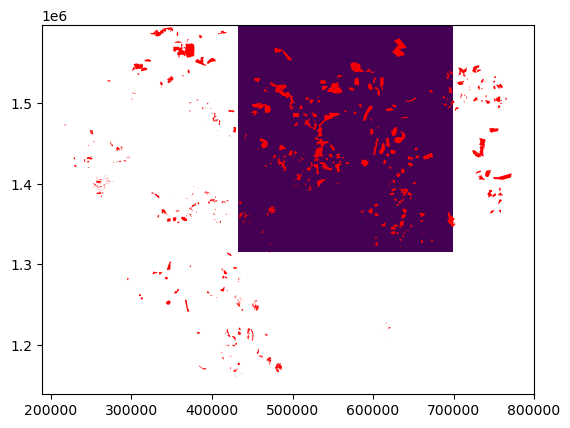

In [179]:
fig, ax = plt.subplots()
show(yod, ax=ax, transform=raster.transform)
polygons_proj.plot(ax=ax, color='red')

### analyze

#### count whole and partial pixels within polygons

##### one polygon

In [180]:
polygon0_gdf = polygons_proj.iloc[[100], :]

<AxesSubplot:>

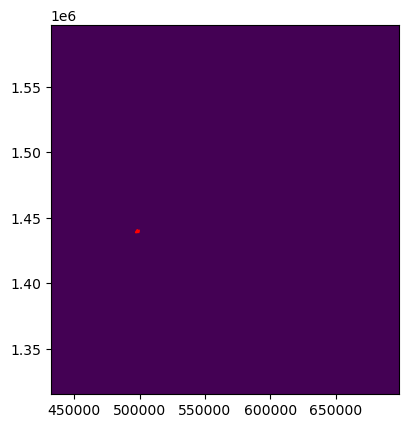

In [181]:
fig, ax = plt.subplots()
show(yod, ax=ax, transform=raster.transform)
polygon0_gdf.plot(ax=ax, color='red')

In [186]:
# both whole and partial cells
mask0_both, mask0_both_transform = mask(raster, polygon0_gdf.geometry, all_touched=True, invert=False, crop=True)

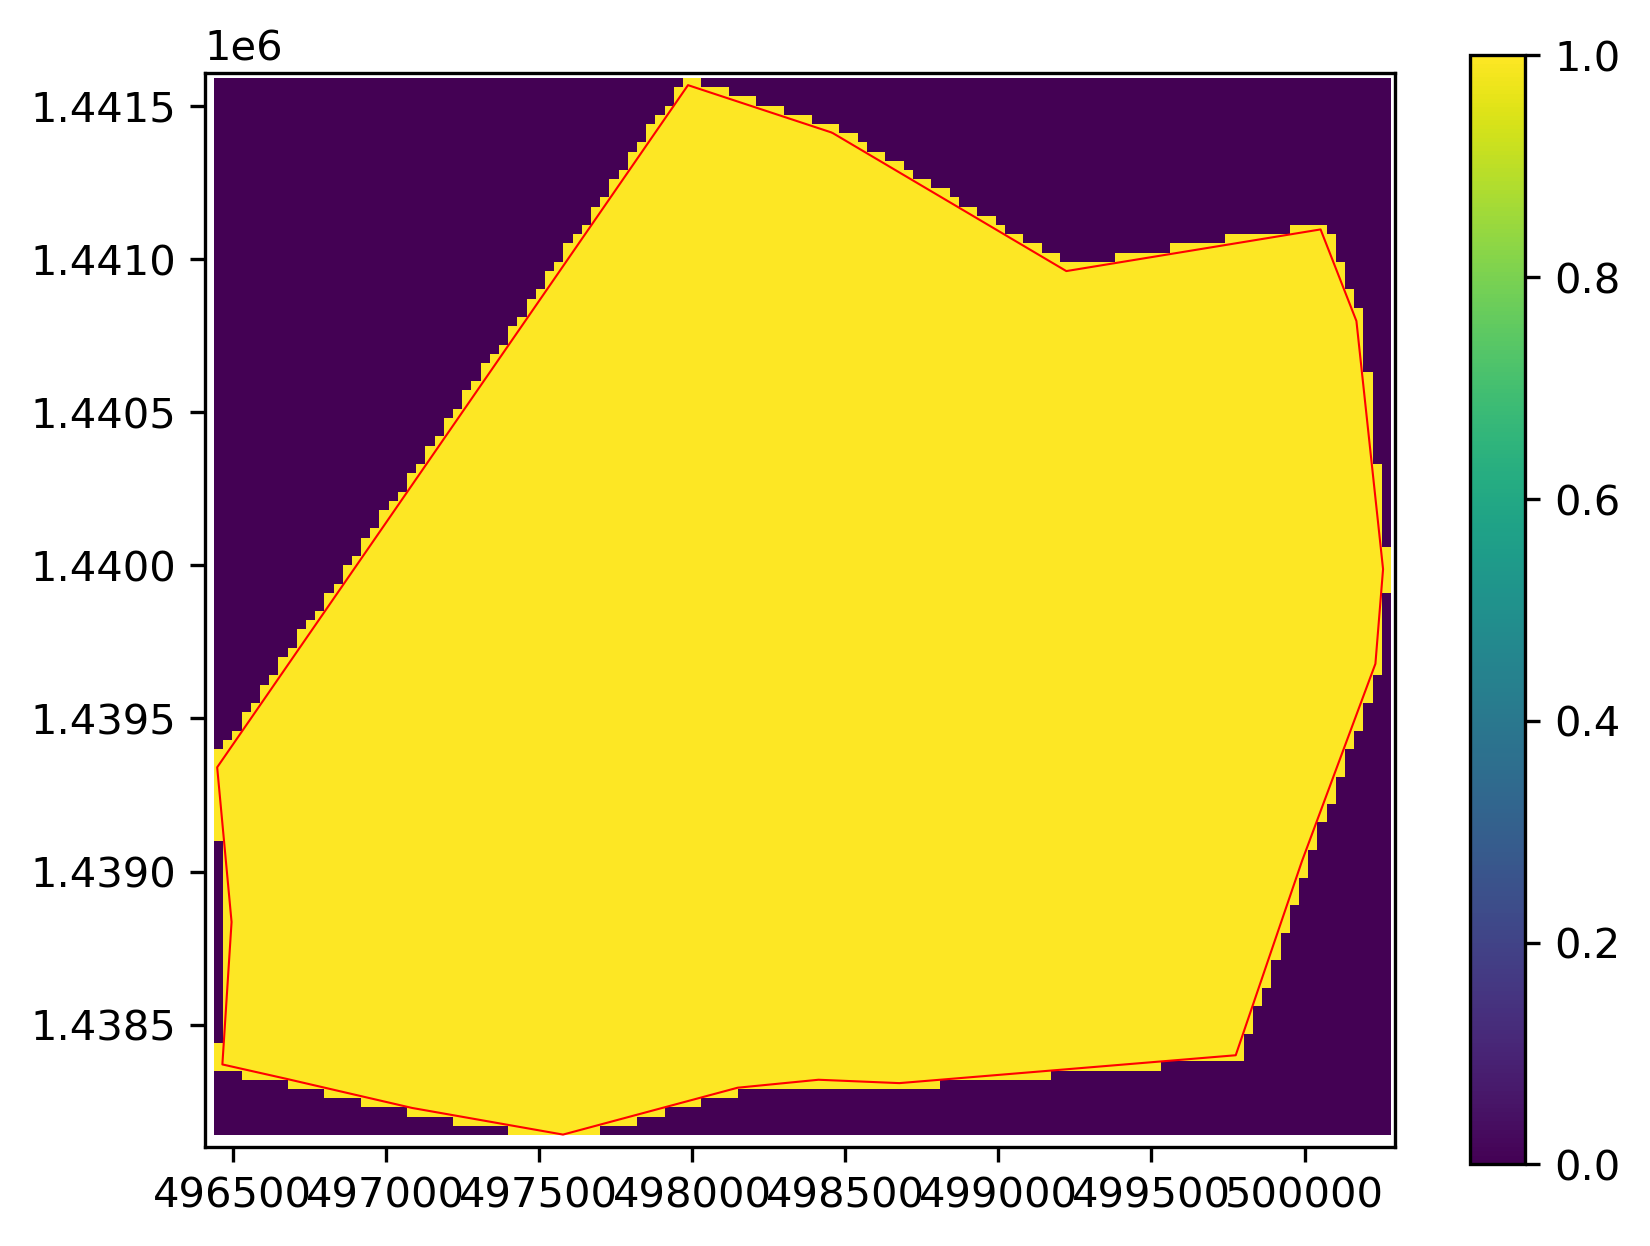

In [187]:
fig, ax = plt.subplots(dpi=300)
img = show(mask0_both, ax=ax, transform=mask0_both_transform)
polygon0_gdf.exterior.plot(ax=ax, color='red', lw=0.5)
minx, miny, maxx, maxy = polygon0_gdf.geometry.squeeze().bounds
plt.xlim(minx-40, maxx+40)
plt.ylim(miny-40, maxy+40)
fig.colorbar(img.get_images()[0], ax=ax)

In [188]:
mask0_both.sum()

10702

In [ ]:
# whole cells

In [204]:
raster_box = box(*list(raster.bounds))

In [265]:
holed_polygon0 = raster_box.difference(polygon0_gdf.geometry.squeeze())

In [266]:
holed_polygon0_gdf = gpd.GeoDataFrame({'geometry': [holed_polygon0]}, crs=raster.crs)

In [267]:
# whole cells
mask0_whole, mask0_whole_transform = mask(raster, holed_polygon0_gdf.geometry, all_touched=True, invert=True, crop=False)

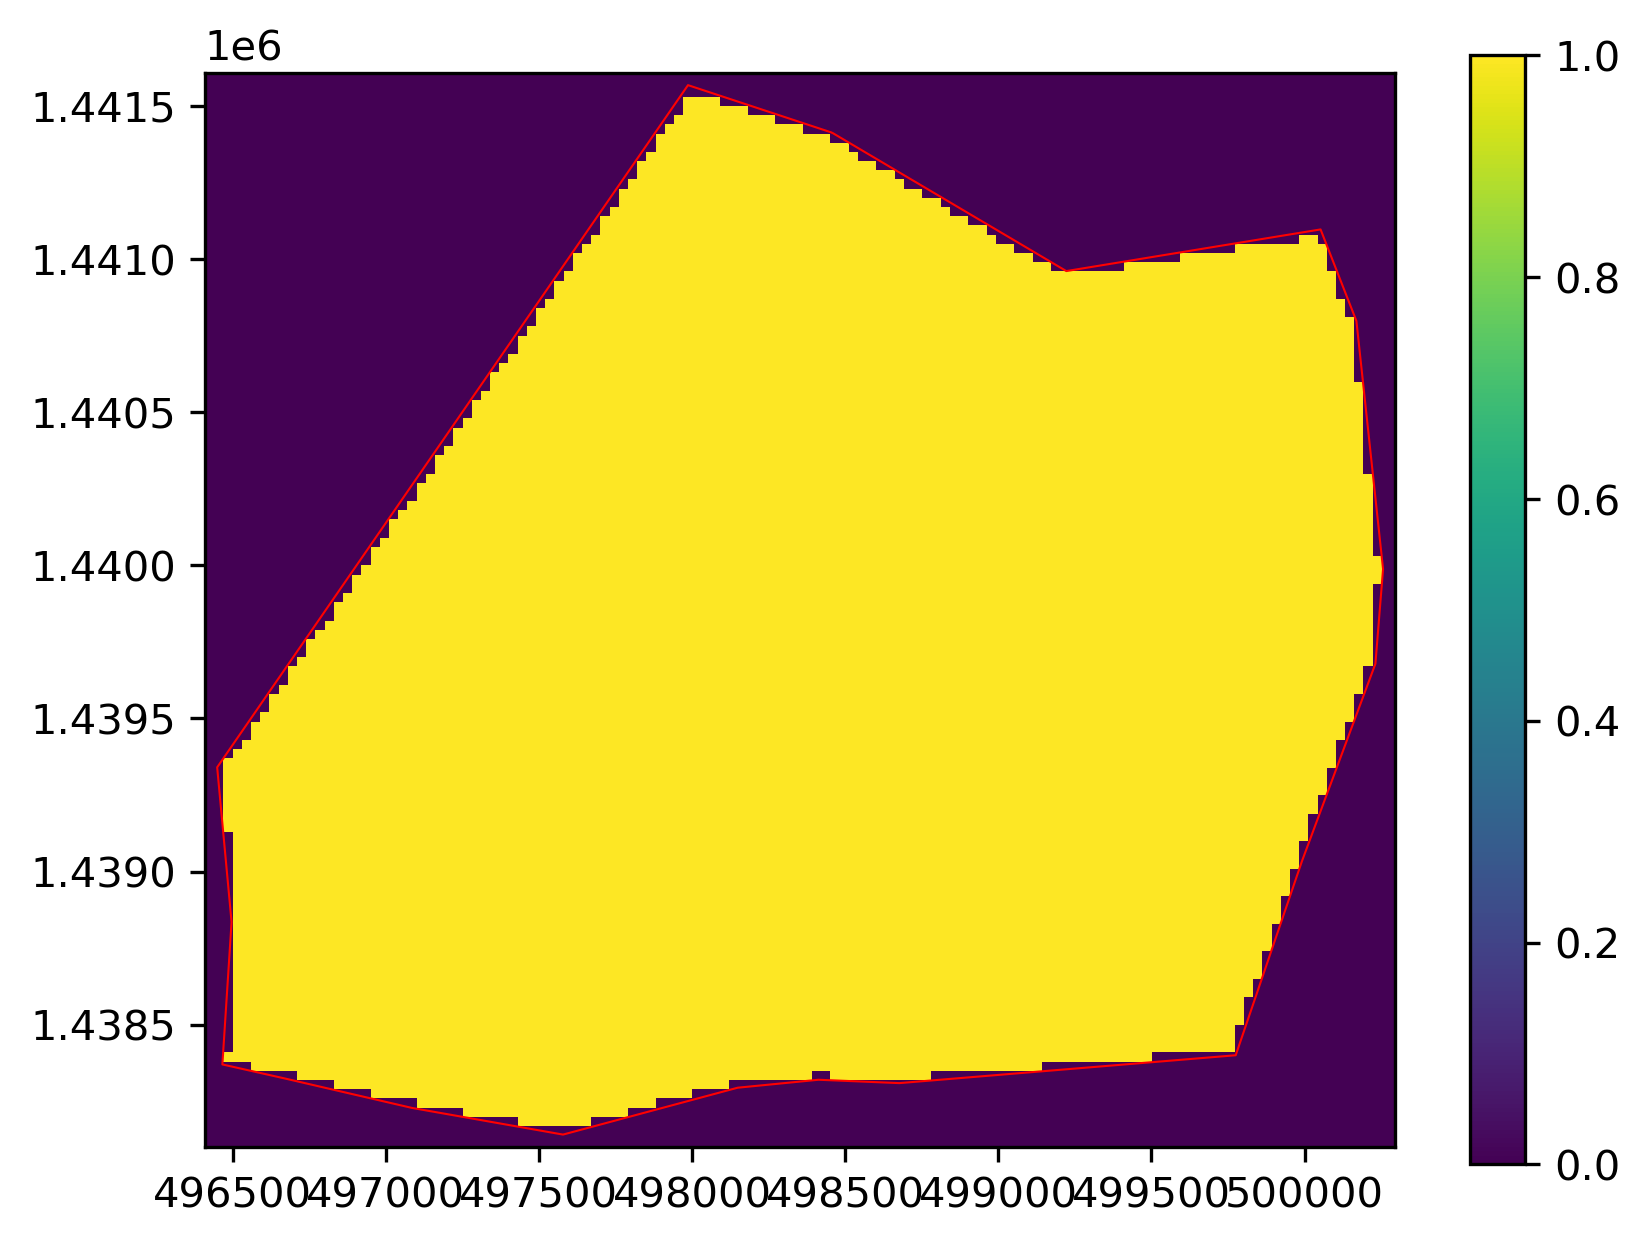

In [280]:
fig, ax = plt.subplots(dpi=300)
img = show(mask0_whole, ax=ax, transform=mask0_whole_transform)
polygon0_gdf.exterior.plot(ax=ax, color='red', lw=0.5)
minx, miny, maxx, maxy = polygon0_gdf.geometry.squeeze().bounds
plt.xlim(minx-40, maxx+40)
plt.ylim(miny-40, maxy+40)
fig.colorbar(img.get_images()[0], ax=ax)

In [281]:
mask0_whole.sum()

10208

In [ ]:
# Create empty lists to store results
whole_cells = []
partial_cells = []

# Iterate over each polygon
for index, polygon in polygons.iterrows():
    # Mask the raster with the polygon geometry
    masked_data, _ = mask(raster, [polygon.geometry], crop=True)
    
    # Calculate the number of cells
    count = (masked_data > 0).sum()
    
    # Determine if the polygon has whole or partial cells
    if count == 0:
        whole_cells.append(0)
        partial_cells.append(0)
    elif count == (masked_data.shape[1] * masked_data.shape[2]):
        whole_cells.append(count)
        partial_cells.append(0)
    else:
        whole_cells.append(0)
        partial_cells.append(count)
        
# Add the results as new columns in the polygon dataframe
polygons['whole_cells'] = whole_cells
polygons['partial_cells'] = partial_cells



In [ ]:
# Save the updated polygon dataframe to a new shapefile
output_file = 'path/to/your/output.shp'
polygons.to_file(output_file)